### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#------------- Supress warnings ---------------
import warnings
warnings.filterwarnings("ignore")

### 2. Read datasets

In [21]:
df = pd.read_csv('data/data.csv')           # source train data
# test = pd.read_csv("dataset/test.csv")          # source test data
# test_set = pd.read_csv("dataset/test.csv") 
# 
df.drop(df[df['matchType']=='flaretpp'].index,inplace=True)

In [22]:
df.to_csv("df.csv",index=False)

In [29]:
df['matchType'].value_counts()

squad-fpp           405
duo-fpp             231
squad               130
solo-fpp            126
duo                  66
solo                 34
normal-squad-fpp      2
flarefpp              2
normal-solo-fpp       1
crashfpp              1
normal-duo-fpp        1
Name: matchType, dtype: int64

## 3. Preprocessing + EDA

### 3.1 Check for null values, missing values and describe data

In [5]:
df.head(10)           # to check if dataset is correct
df.describe()         # look for mean, min, max
df.info()             # columns info 
df.isnull().sum()     
df.isna().sum()

test.head(10)           # to check if dataset is correct
test.describe()         # look for mean, min, max
test.info()             # columns info 
test.isnull().sum()     
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112876 entries, 0 to 3112875
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [34]:
# ------ Since winPlacePerc has only 1 missing value we replace it with mean ----------
df['winPlacePerc'].fillna(value=df.winPlacePerc.mean(), inplace=True)

### Feature Engineering + dropping

In [5]:
# finding those wrong combinations of solo/duo and players count
# solo can not have >1 player
# duo can not have >2 players
indexdrop = df[((df.matchType=='solo') & (df.groupId.value_counts()>1)) | ((df.matchType=='duo') & (df.groupId.value_counts()>2))]
print(indexdrop)

# *******OBSERVATION********* 
# no mismatch found
# ***************************

# ------------------ Count of each groupId ------------------ 

series = df.groupId.value_counts()
count = 0
for i in series:
    if i>4:
        count = count + 1;
print(count)
# ------------------ NOTE -----------------
# 48412 groupIds have more than 4 players which is not possible
# so we can remove them

******** Perform drop *********
out_groupId = df.groupby('groupId').filter(lambda x : len(x)>4).groupId
df.drop(out_groupId.index,inplace=True)

# -------------- create new column players count ------------------
df['players_count'] = df.groupby('matchId')['matchId'].transform('count')
test['players_count'] = test.groupby('matchId')['matchId'].transform('count')

# -------------- new column headshot rate -------------------------
df['headshot_rate'] = df.headshotKills/df.kills
df.headshot_rate = df.headshot_rate.fillna(0)
test['headshot_rate'] = test.headshotKills/df.kills
test.headshot_rate = test.headshot_rate.fillna(0)

# --------------- new column total distance -------------------
df['distance'] = df.walkDistance+df.swimDistance+df.rideDistance
test['distance'] = test.walkDistance+test.swimDistance+test.rideDistance
df.drop(['walkDistance','swimDistance','rideDistance'],axis=1,inplace=True)
test.drop(['walkDistance','swimDistance','rideDistance'],axis=1,inplace=True)

# ---------------- new column aid ------------------
df['aid'] = df.heals+df.boosts
test['aid'] = test.heals+test.boosts
df.drop(['heals','boosts'],axis=1,inplace=True)
test.drop(['heals','boosts'],axis=1,inplace=True)

### 3.2 Dropping Id columns

In [8]:
# # ---- Id of the match, group and player is unique to the player and match so it should not influence winning place ---- #

df.drop(['matchId','groupId','Id'],axis=1,inplace=True)
test.drop(['matchId','groupId','Id'],axis=1,inplace=True)

### Dropping anomalies

In [36]:
# --------- headshot rate 100% with more than 10 kills is near to impossible -----------
head_kill_out = df[(df.headshot_rate==1) & (df.kills>=10)].index
df.drop(head_kill_out,inplace=True)

# ---------------- Kills without moving -------------
kill_no_move = df[(df.kills>0) & (df.distance==0)].index
df.drop(kill_no_move,inplace=True)

# ---------- killing over 500m is not possible ------------
# because even with 8x scope you can not see more than 500m
impossible_kill = df[df.longestKill>1000].index
df.drop(impossible_kill,inplace=True)

### Dealing with categorical data

### 3.3 Encoding match type
One-hot encoding is the representation of categorical variables as binary vectors. Label Encoding is converting labels/words into numeric form

We choose one-hot enconding because we do not want to assign weightage to any match type and treat all types equal for predicting result

#### On our observation information through mutual info performed better than correlation 
![](2022-10-20-19-47-12.png)
![](2022-10-20-19-47-40.png)

In [10]:
# ----------- Since matchType is a category we are using one hot encoder -----------------

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# By specifying remainder='passthrough', all remaining columns that were not specified
# in transformers will be automatically passed through
transformer = make_column_transformer((OneHotEncoder(), ['matchType']),remainder='passthrough')

# transformed contains transformed columns, now convert it into dataframe and give columns default encoded names
transformed = transformer.fit_transform(df)              
final_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

transformed = transformer.fit_transform(test)
final_test = pd.DataFrame( transformed,columns=transformer.get_feature_names())

# since coulmn transformer made our dataframe lables type=object we convert it to float 
final_df = final_df.astype(float)
final_test = final_test.astype(float)

In [11]:
# ----------------- One anomaly in headshot rate is treated here ------------
final_test.headshot_rate.replace(final_test.headshot_rate.max(),0,inplace=True)

### 3.4 Feature Selection

#### 3.5 Mutual information gain

In [51]:
from sklearn.feature_selection import mutual_info_regression

# Take 3 Lakh rows for sampling
one = final_df.sample(500000)       # 15 min

# Find mutual relationship between winPlacePerc and other columns
mutual_info = mutual_info_regression(one.drop('winPlacePerc',axis=1),one.winPlacePerc) 

In [52]:
mutual_info =  pd.Series(mutual_info)                           # make series of mutual_info
mutual_info.index = one.drop('winPlacePerc',axis=1).columns     # drop final label
mutual_info = mutual_info.sort_values(ascending=False)          # sort values in descending order

print(mutual_info)

maxPlace                              2.383306
numGroups                             1.197960
killPlace                             0.951188
walkDistance                          0.742779
weaponsAcquired                       0.323713
boosts                                0.322173
onehotencoder__x0_squad-fpp           0.269480
onehotencoder__x0_duo-fpp             0.236813
heals                                 0.198098
damageDealt                           0.163317
onehotencoder__x0_solo-fpp            0.159959
longestKill                           0.147384
kills                                 0.128329
rideDistance                          0.121461
DBNOs                                 0.112635
killStreaks                           0.102216
onehotencoder__x0_squad               0.075194
assists                               0.067226
rankPoints                            0.064652
onehotencoder__x0_duo                 0.060103
revives                               0.057010
matchDuration

### 3.6 Correlation matrix

In [14]:
# Check correlation of winning place with features
corr_feature = final_df.corr().winPlacePerc.abs()
corr_feature.sort_values(ascending=False)

### 3.5 Dropping less important features

In [12]:
# threshold set for info_gain > 0.05

futile_features = ['onehotencoder__x0_normal-duo-fpp',
                   'onehotencoder__x0_flarefpp',
                   'onehotencoder__x0_normal-squad',
                   'onehotencoder__x0_normal-solo',
                   'onehotencoder__x0_crashtpp',
                   'roadKills',
                   'onehotencoder__x0_crashfpp',
                   'onehotencoder__x0_normal-duo',
                   'onehotencoder__x0_flaretpp',
                   'onehotencoder__x0_normal-solo-fpp',
                   'onehotencoder__x0_normal-squad-fpp',
                   'vehicleDestroys',
                   'teamKills',
                   'killPoints',
                   'winPoints',
                   'matchDuration',
                   'onehotencoder__x0_solo',
                   'headshotKills',
                   'headshotKills']

# Drop features in both test and train data (18 columsn dropped)
final_df.drop(futile_features, axis=1, inplace=True)       
final_test.drop(futile_features, axis=1, inplace=True)

### 3.6 Outlier detection

C:\Users\Asus\AppData\Local\Temp\ipykernel_18024\41616203.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


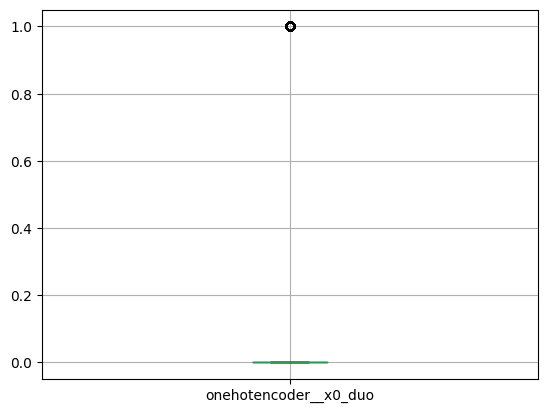

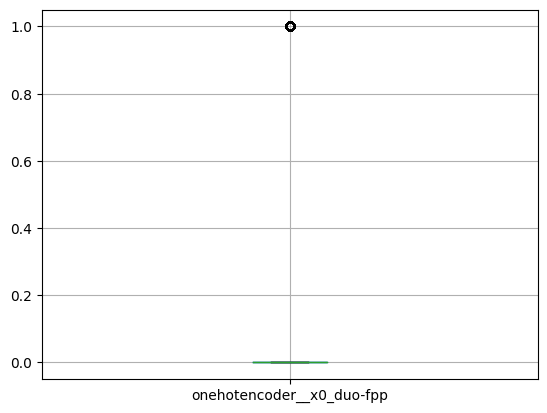

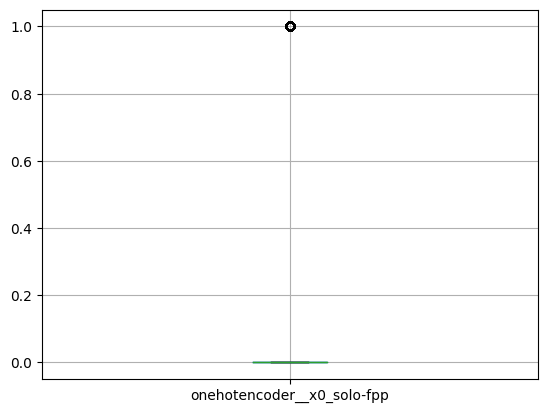

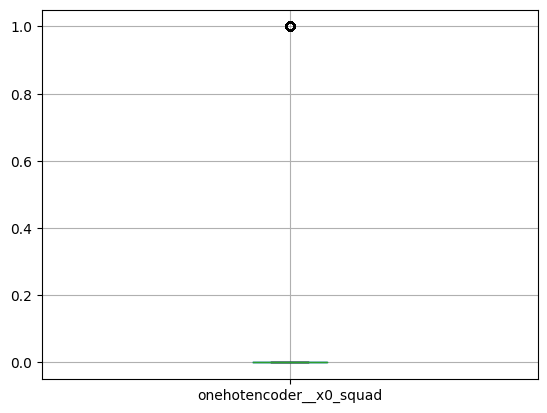

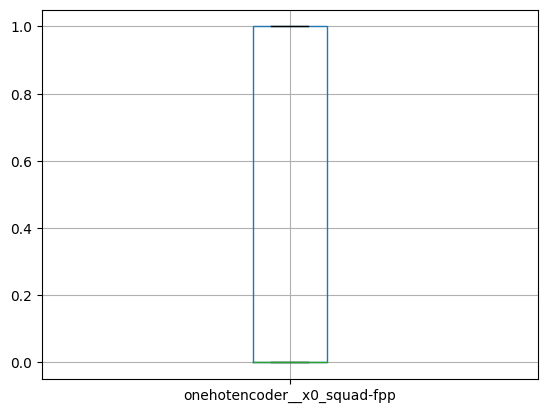

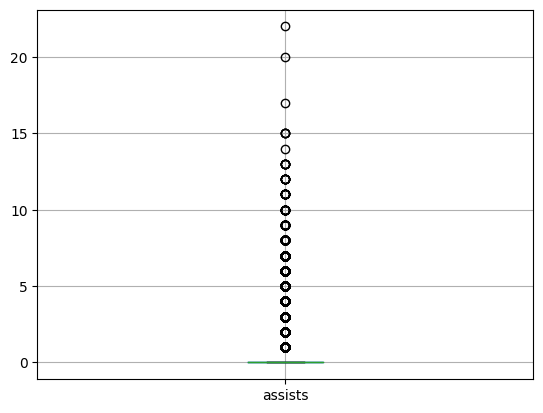

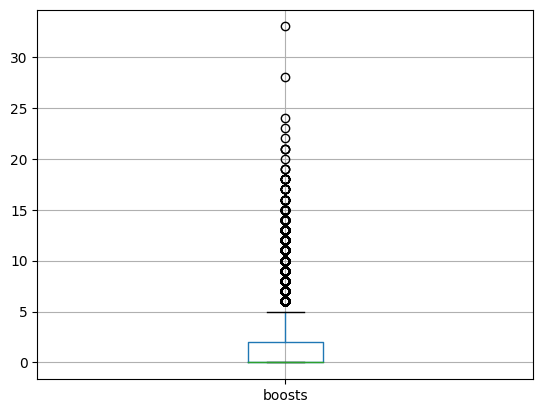

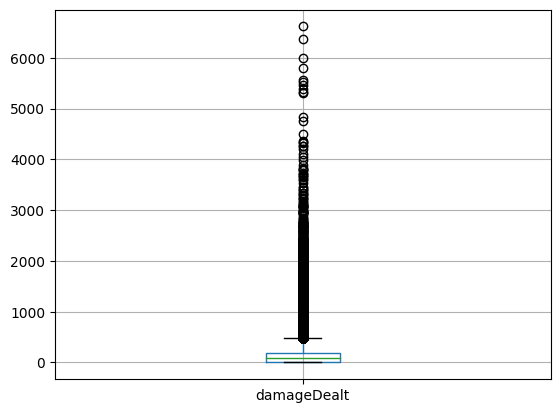

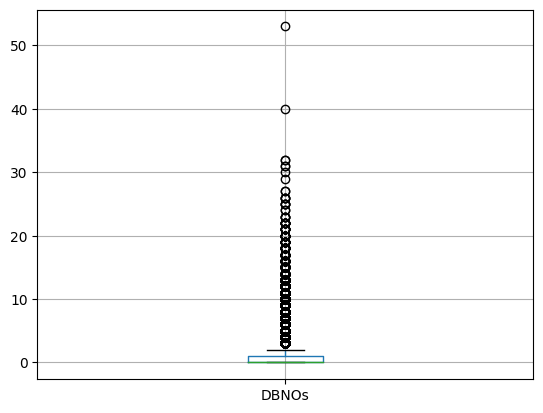

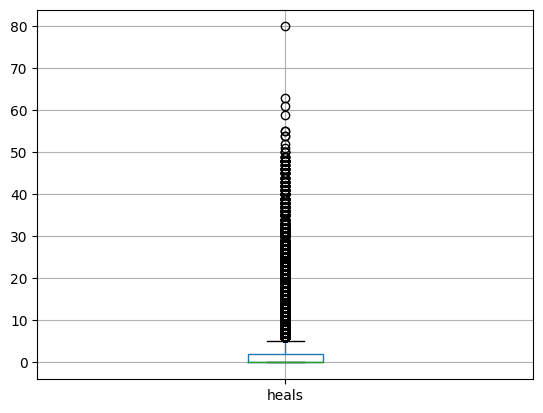

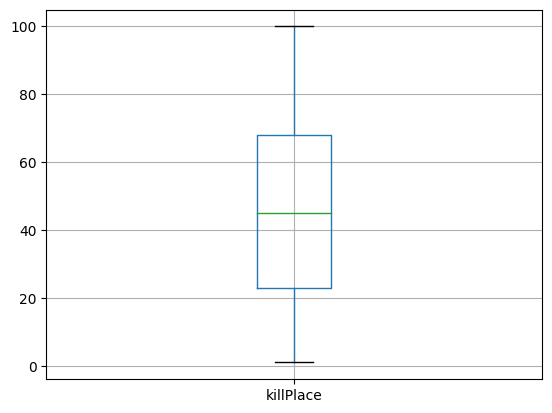

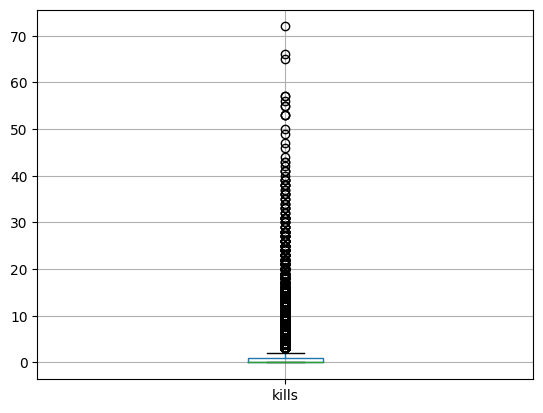

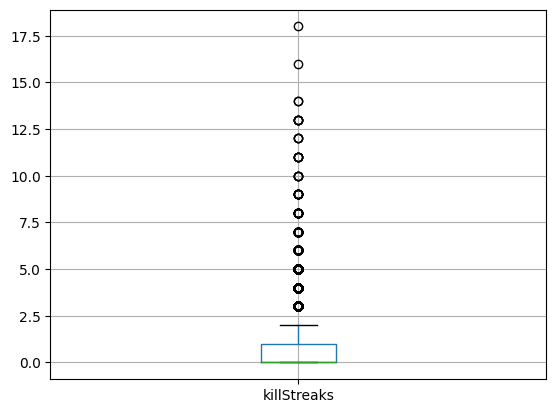

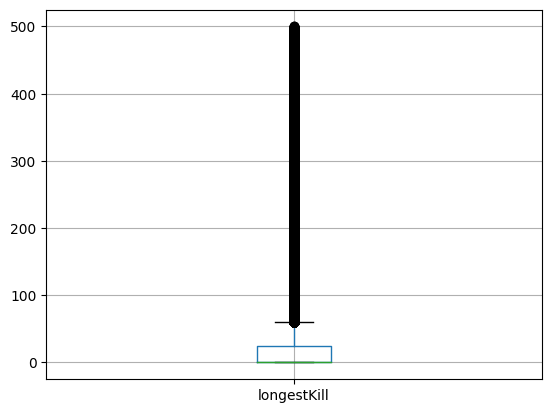

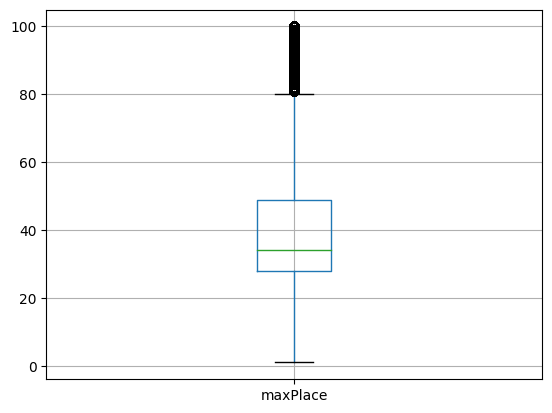

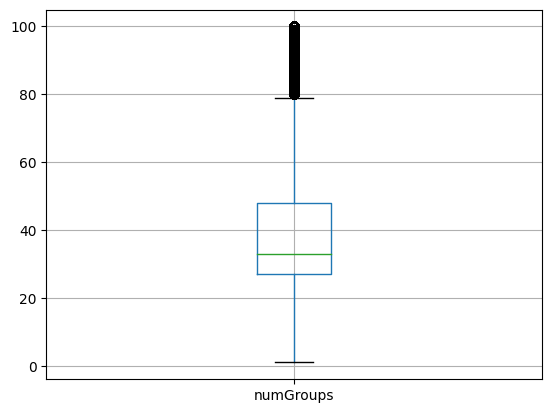

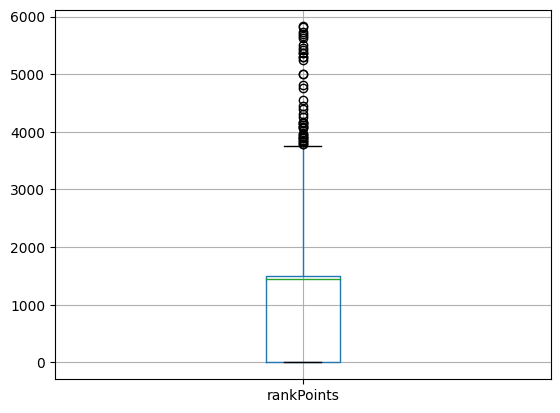

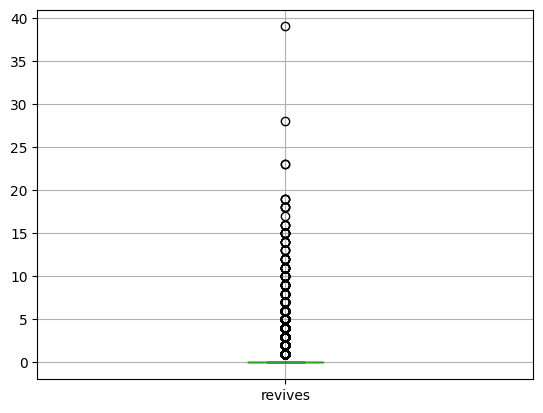

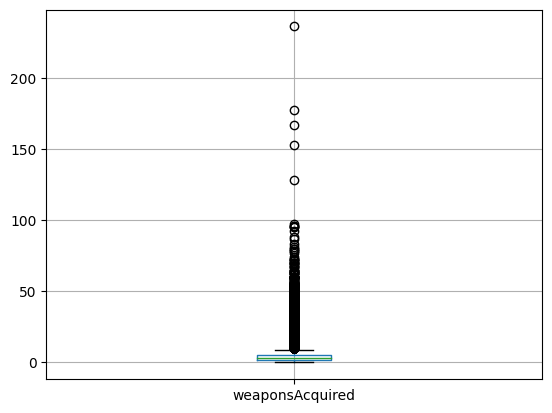

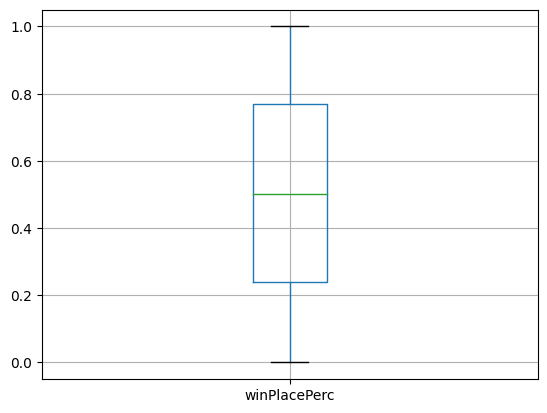

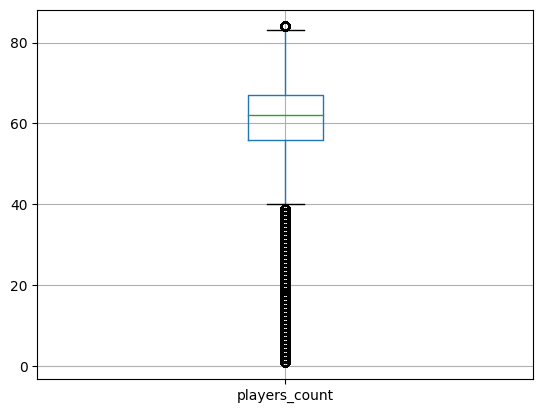

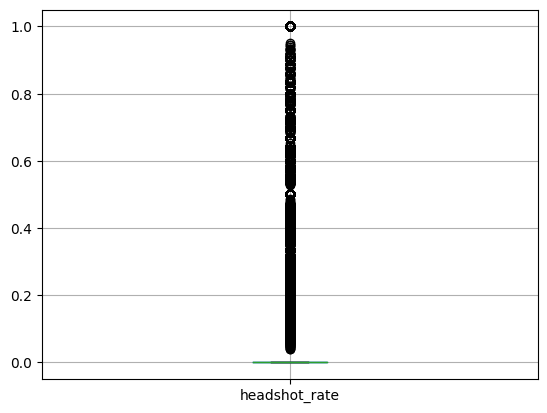

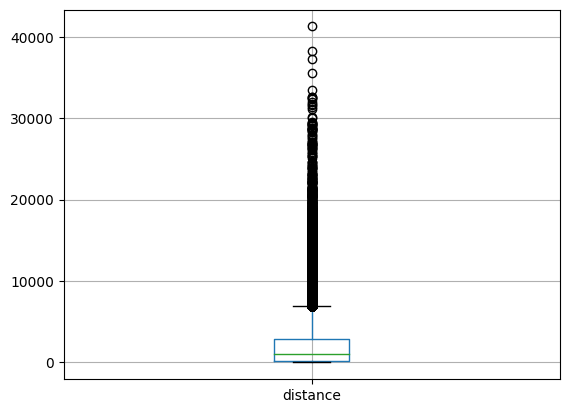

In [64]:
# Boxplots for each feature
for column in final_df:
    plt.figure()
    final_df.boxplot([column])

### 3.7 Outliers capping

In [55]:
# --------------- Set limits to outliers based on boxplot result ---------------

# Limits for features
out_assists = 15
out_damageDealt = 5000
out_DBNOs = 35
out_kills = 40
out_killStreaks = 15
# out_aid = 60
out_revives = 20
# out_distance = 35000
out_weaponsAcquired = 100

# Apply limits to training set
final_df.assists[final_df.assists>out_assists] = out_assists
final_df.damageDealt[final_df.damageDealt>out_damageDealt] = out_damageDealt
final_df.DBNOs[final_df.DBNOs>out_DBNOs] = out_DBNOs
final_df.kills[final_df.kills>out_kills] = out_kills
# final_df.aid[final_df.aid>out_aid] = out_aid
final_df.killStreaks[final_df.killStreaks>out_killStreaks] = out_killStreaks
final_df.revives[final_df.revives>out_revives] = out_revives
# final_df.distance[final_df.distance>out_distance] = out_distance
final_df.weaponsAcquired[final_df.weaponsAcquired>out_weaponsAcquired] = out_weaponsAcquired

# Apply limits to test set
final_test.assists[final_test.assists>out_assists] = out_assists
final_test.damageDealt[final_test.damageDealt>out_damageDealt] = out_damageDealt
final_test.DBNOs[final_test.DBNOs>out_DBNOs] = out_DBNOs
final_test.kills[final_test.kills>out_kills] = out_kills
# final_test.aid[final_test.aid>out_aid] = out_aid
final_test.killStreaks[final_test.killStreaks>out_killStreaks] = out_killStreaks
final_test.revives[final_test.revives>out_revives] = out_revives
# final_test.distance[final_test.distance>out_distance] = out_distance
final_test.weaponsAcquired[final_test.weaponsAcquired>out_weaponsAcquired] = out_weaponsAcquired

## 4 Training the model

### 4.1 Train test split

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = final_df.drop(['winPlacePerc'], axis=1)
y = final_df.winPlacePerc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)   # 30% test, 70% train split

## 4.2 LG Boost

In [30]:
import lightgbm as lgb

param_test ={
        'num_leaves': sp_randint(6, 512), 
        'subsample': sp_uniform(loc=0.2, scale=0.8), 
        'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
        'metric': ['l1','l2'],
        'bagging_fraction': (0.5,0.7,0.9),
        'bagging_freq': (1,10,15,20),
        'max_bin': (128,264,512,1024),
        'learning_rate': (0.03,0.05,0.07,0.09)
        }

gbm = lgb.LGBMRegressor(max_depth=-1, random_state=31, n_jobs=4, n_estimators=500)

rs = RandomizedSearchCV(
    estimator=gbm, param_distributions=param_test, 
    cv=3,
    random_state=31,
    verbose=True)

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.07,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 2,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 10000           # 32min
}

gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
y_test_perd = gbm.predict(final_test, num_iteration=gbm.best_iteration_)

# MAE = 0.06370080370165758

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.786165
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.339062
[LightGBM] [Debug] init for col-wise cost 0.042512 seconds, init for row-wise cost 0.247657 seconds
[LightGBM] [Warning] Auto-choosing row-wi

### 4.3 Check MAE 

In [15]:
import sklearn.metrics as metrics

metrics.mean_absolute_error(y_test,y_pred)
# 0.05609854569635893 best achieved result

0.10709587761124044

## 5. Post processing 

### 5.1 Capping winning percentage values

In [32]:
# ------- Since predicted winning percentage may not lie in range [0,1] we bring them in range --------- #

# For split test set
y_pred[y_pred>1] = 1
y_pred[y_pred<0] = 0

# For test set
y_test_perd[y_test_perd>1] = 1
y_test_perd[y_test_perd<0] = 0